Mounted at /content/drive

=== A) Interaction Terms (pairwise, numeric-only) ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Baseline KNN — CV Acc: 0.6380 ± 0.0065 (folds=2) | Test: 0.6484


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


With Interaction Terms — CV Acc: 0.5549 ± 0.0077 (folds=2) | Test: 0.5813
Numeric features before: 10 | after interactions: 55

=== B) Crop clustering based on similarity (with silhouette per k) ===
Silhouette scores by k:
  k = 2 → silhouette = 0.2681
  k = 3 → silhouette = 0.2701
  k = 4 → silhouette = 0.2765
  k = 5 → silhouette = 0.2794
  k = 6 → silhouette = 0.2791
  k = 7 → silhouette = 0.2930
  k = 8 → silhouette = 0.2920
  k = 9 → silhouette = 0.2825
  k = 10 → silhouette = 0.2337
  k = 11 → silhouette = 0.2597


,k,silhouette_score
0,2,0.268080
1,3,0.270079
2,4,0.276491
3,5,0.279437
4,6,0.279057
5,7,0.292994
6,8,0.291994
7,9,0.282513
8,10,0.233693
9,11,0.259708


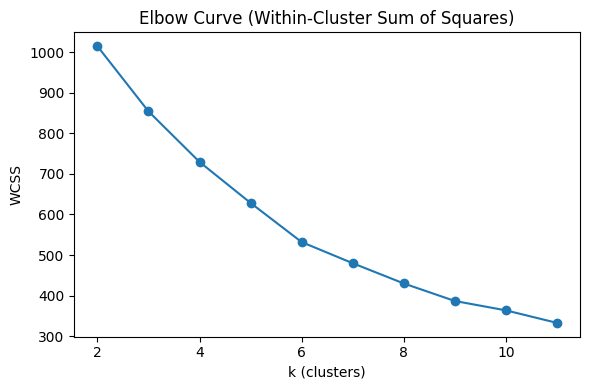

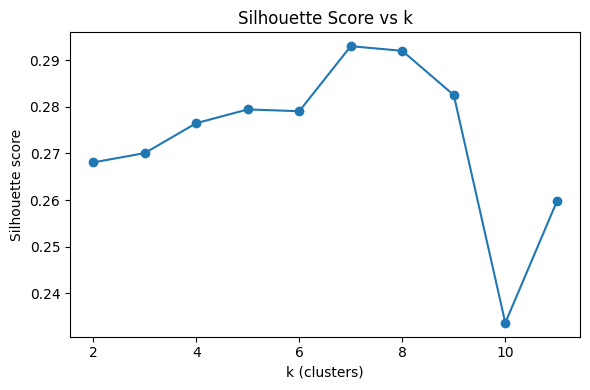


Chosen k (by max silhouette): 7 | silhouette = 0.2930
Final silhouette for k=7: 0.2930


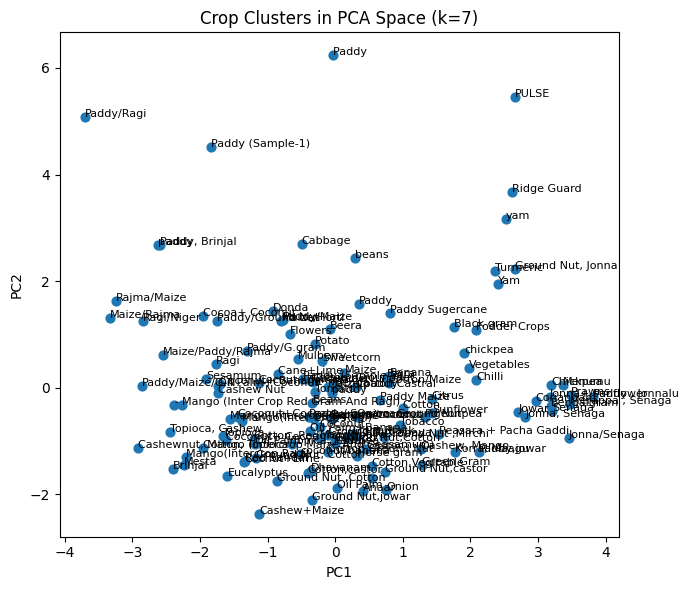

,crop,cluster
0,,0
1,Anaar,0
2,Bajra,0
3,Banana,0
4,Banana/coconut,0
...,...,...
124,Vegetables,4
125,Prawns,5
126,PULSE,6
127,Paddy,6



=== C) Dimensionality Reduction (PCA) ===


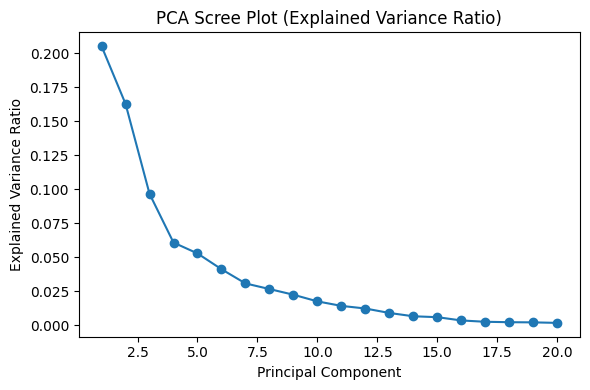

Cumulative variance with first 2 PCs: 0.3679
Cumulative variance with first 5 PCs: 0.5783
Cumulative variance with first 10 PCs: 0.7175


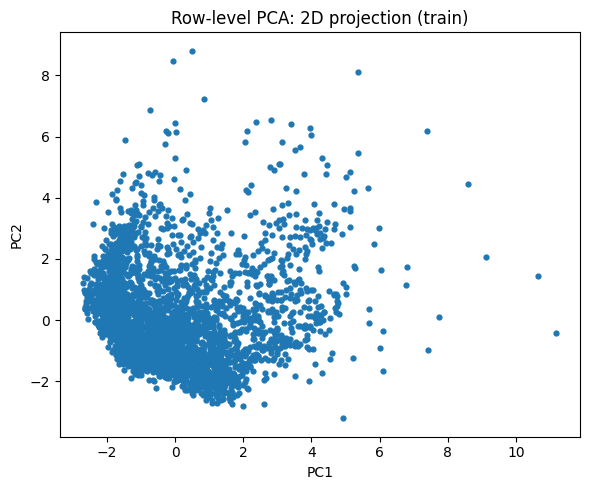

KNN on full engineered matrix — Test Acc: 0.6484
KNN on top 10 PCs     — Test Acc: 0.5488

Notes:
- Scaling (z-score) is applied before distance-based methods (KNN, K-Means) and PCA, per the PDF.
- Categorical features are one-hot encoded before PCA and clustering, per the PDF.
- PCA shows variance captured and provides a 2D projection; use first m PCs to reduce dimensionality.


In [1]:
# --- 0) Setup (Colab + Libraries) ---
# If using Google Drive:
USE_DRIVE = True           # <- set False to upload file instead
DATA_PATH = "/content/drive/MyDrive/mainproject/AP_data.csv"  # change this if using Drive

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- 1) Load data ----------
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    assert os.path.exists(DATA_PATH), f"CSV not found at: {DATA_PATH}"
    path = DATA_PATH
else:
    from google.colab import files
    uploaded = files.upload()
    path = list(uploaded.keys())[0]

df = pd.read_csv(path)
df.columns = [c.strip().replace('\n',' ').replace('\t',' ').replace('  ',' ') for c in df.columns]

TARGET = "crop before"
if TARGET not in df.columns:
    matches = [c for c in df.columns if c.lower().replace('_',' ').strip() == TARGET]
    if not matches:
        raise ValueError(f"Target '{TARGET}' not found. Columns: {list(df.columns)}")
    TARGET = matches[0]

# Columns per your dataset spec
feature_list = ["pH","EC","OC","Avail-P","Exch-K","Avail-Ca","Avail-Mg","Avail-S",
                "Avail-Zn","Avail-B","Avail-Fe","Avail-Cu","Avail-Mn","Soil type","Season"]

present = [c for c in df.columns if c.strip().lower() in {x.lower() for x in feature_list}]
X = df[present].copy()
y_raw = df[TARGET].astype(str)

# Drop rows with all features missing or missing target
mask_nan_all = X.isna().all(axis=1)
X = X[~mask_nan_all]
y_raw = y_raw.loc[X.index]

# --- Group very rare labels -> "Other" to enable stratified splits
MIN_COUNT = 2
vc = y_raw.value_counts()
rare = set(vc[vc < MIN_COUNT].index)
y = y_raw.apply(lambda v: "Other" if v in rare else v)
if y.nunique() < 2:
    raise ValueError("Only one class after grouping rare labels. Reduce MIN_COUNT or inspect data.")

# ---------- 2) Split (Stratified) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# ---------- 3) Preprocessing aligned with PDF ----------
# Per PDF: scale numeric features (z-score) for distance-based algorithms & PCA; one-hot encode categoricals
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # z-score normalization per PDF
])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # OHE per PDF
])

base_pre = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

def safe_cv_scores(pipe, Xtr, ytr, nmax=5):
    """Stratified K-fold CV with folds <= min class count (robust for imbalanced data)."""
    min_class = ytr.value_counts().min()
    n_splits = int(min(nmax, max(2, min_class)))
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, Xtr, ytr, scoring="accuracy", cv=cv, n_jobs=-1)
    return scores.mean(), scores.std(), n_splits

# ============================================================
# A) INTERACTION TERMS  (PDF: "Feature Construction" — derived features)
# ============================================================
print("\n=== A) Interaction Terms (pairwise, numeric-only) ===")
# Baseline KNN (distance-based -> scaling already applied)
baseline_pipe = Pipeline(steps=[("preprocess", base_pre),
                               ("clf", KNeighborsClassifier(n_neighbors=9, weights="distance"))])
base_mean, base_std, base_folds = safe_cv_scores(baseline_pipe, X_train, y_train)
baseline_pipe.fit(X_train, y_train)
base_test = accuracy_score(y_test, baseline_pipe.predict(X_test))
print(f"Baseline KNN — CV Acc: {base_mean:.4f} ± {base_std:.4f} (folds={base_folds}) | Test: {base_test:.4f}")

# Add pairwise interaction-only terms for numerics (degree=2, no squares)
poly_numeric = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])
inter_pre = ColumnTransformer(
    transformers=[
        ("num_inter", poly_numeric, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)
inter_pipe = Pipeline(steps=[("preprocess", inter_pre),
                             ("clf", KNeighborsClassifier(n_neighbors=9, weights="distance"))])
inter_mean, inter_std, inter_folds = safe_cv_scores(inter_pipe, X_train, y_train)
inter_pipe.fit(X_train, y_train)
inter_test = accuracy_score(y_test, inter_pipe.predict(X_test))
print(f"With Interaction Terms — CV Acc: {inter_mean:.4f} ± {inter_std:.4f} (folds={inter_folds}) | Test: {inter_test:.4f}")

# Report dimensionality growth on numeric side
inter_pre.fit(X_train)
base_pre.fit(X_train)
if len(num_cols):
    base_num_dim = base_pre.named_transformers_["num"]["scaler"] \
        .fit_transform(base_pre.named_transformers_["num"]["imputer"].transform(X_train[num_cols])).shape[1]
    inter_num_dim = inter_pre.named_transformers_["num_inter"]["poly"] \
        .fit_transform(inter_pre.named_transformers_["num_inter"]["scaler"] \
        .fit_transform(inter_pre.named_transformers_["num_inter"]["imputer"].transform(X_train[num_cols]))).shape[1]
    print(f"Numeric features before: {base_num_dim} | after interactions: {inter_num_dim}")

# ============================================================
# B) CROP CLUSTERING BASED ON SIMILARITY — with silhouette by k
# ============================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

print("\n=== B) Crop clustering based on similarity (with silhouette per k) ===")

# 1) Aggregate mean numeric soil profile per crop
num_only = [c for c in feature_list if (c in df.columns and pd.api.types.is_numeric_dtype(df[c]))]
agg = df.groupby(TARGET)[num_only].mean().dropna(how="all").dropna(axis=0, how="any")
crop_names = agg.index.tolist()

# 2) Scale (z-score) before distance-based clustering
scaler = StandardScaler()
agg_scaled = scaler.fit_transform(agg.values)

# 3) Evaluate multiple k values: WCSS (elbow) and silhouette
Ks = list(range(2, min(12, len(agg_scaled))))  # at least 2 clusters
wcss = []
silhouette_scores = []

print("Silhouette scores by k:")
for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(agg_scaled)
    wcss.append(km.inertia_)
    sil = silhouette_score(agg_scaled, labels)
    silhouette_scores.append(sil)
    print(f"  k = {k} → silhouette = {sil:.4f}")

# Show results as a small table
sil_df = pd.DataFrame({"k": Ks, "silhouette_score": silhouette_scores})
display(sil_df)

# 4) Plot Elbow curve (WCSS)
plt.figure(figsize=(6,4))
plt.plot(Ks, wcss, marker="o")
plt.title("Elbow Curve (Within-Cluster Sum of Squares)")
plt.xlabel("k (clusters)")
plt.ylabel("WCSS")
plt.tight_layout()
plt.show()

# 5) Plot Silhouette vs k
plt.figure(figsize=(6,4))
plt.plot(Ks, silhouette_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k (clusters)")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

# 6) Choose k_best using the highest silhouette score (tie → smallest k)
best_idx = int(pd.Series(silhouette_scores).idxmax())
k_best = Ks[best_idx]
print(f"\nChosen k (by max silhouette): {k_best} | silhouette = {silhouette_scores[best_idx]:.4f}")

# 7) Fit final KMeans with k_best, compute silhouette, and visualize in PCA space
kmeans = KMeans(n_clusters=k_best, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(agg_scaled)
sil_final = silhouette_score(agg_scaled, clusters) if len(np.unique(clusters)) > 1 else float("nan")
print(f"Final silhouette for k={k_best}: {sil_final:.4f}")

# 8) 2D PCA scatter with crop labels (interpretation view)
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
agg_pca2 = pca2.fit_transform(agg_scaled)

plt.figure(figsize=(7,6))
plt.scatter(agg_pca2[:,0], agg_pca2[:,1], s=40)
for i, name in enumerate(crop_names):
    plt.text(agg_pca2[i,0], agg_pca2[i,1], name, fontsize=8)
plt.title(f"Crop Clusters in PCA Space (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 9) Cluster membership table
cluster_df = pd.DataFrame({"crop": crop_names, "cluster": clusters})
display(cluster_df.sort_values(["cluster","crop"]).reset_index(drop=True))


# (Optional) Cosine similarity demonstration (per PDF): show pairwise cosine on scaled means
# from sklearn.metrics.pairwise import cosine_similarity
# cos_sim = cosine_similarity(agg_scaled)
# display(pd.DataFrame(cos_sim, index=crop_names, columns=crop_names).round(3))

# ============================================================
# C) DIMENSIONALITY REDUCTION (PCA) — scaled inputs per PDF
# ============================================================
print("\n=== C) Dimensionality Reduction (PCA) ===")
# Fit preprocessing on train; transform to a numeric matrix (OHE included)
full_pre = base_pre.fit(X_train, y_train)
Xtr = full_pre.transform(X_train)
Xte = full_pre.transform(X_test)

# Scree plot: explained variance ratio
max_comps = min(20, Xtr.shape[1])
pca_full = PCA(n_components=max_comps, random_state=RANDOM_STATE).fit(Xtr)

plt.figure(figsize=(6,4))
plt.plot(range(1, max_comps+1), pca_full.explained_variance_ratio_, marker="o")
plt.title("PCA Scree Plot (Explained Variance Ratio)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

cum = np.cumsum(pca_full.explained_variance_ratio_)
for k in [2,5,10]:
    if k <= max_comps:
        print(f"Cumulative variance with first {k} PCs: {cum[k-1]:.4f}")

# 2D PCA projection for visualization
pca2_all = PCA(n_components=2, random_state=RANDOM_STATE)
Xtr_2d = pca2_all.fit_transform(Xtr)

plt.figure(figsize=(6,5))
plt.scatter(Xtr_2d[:,0], Xtr_2d[:,1], s=12)
plt.title("Row-level PCA: 2D projection (train)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Quick accuracy check: KNN on top 10 PCs vs. on full engineered feature matrix
from sklearn.neighbors import KNeighborsClassifier
top_k_pcs = min(10, Xtr.shape[1])
pca10 = PCA(n_components=top_k_pcs, random_state=RANDOM_STATE).fit(Xtr)
Xtr_pca10 = pca10.transform(Xtr); Xte_pca10 = pca10.transform(Xte)

knn_raw = KNeighborsClassifier(n_neighbors=9, weights="distance").fit(Xtr, y_train)
knn_pca = KNeighborsClassifier(n_neighbors=9, weights="distance").fit(Xtr_pca10, y_train)

raw_acc = accuracy_score(y_test, knn_raw.predict(Xte))
pca_acc = accuracy_score(y_test, knn_pca.predict(Xte_pca10))
print(f"KNN on full engineered matrix — Test Acc: {raw_acc:.4f}")
print(f"KNN on top {top_k_pcs} PCs     — Test Acc: {pca_acc:.4f}")

print("\nNotes:")
print("- Scaling (z-score) is applied before distance-based methods (KNN, K-Means) and PCA, per the PDF.")
print("- Categorical features are one-hot encoded before PCA and clustering, per the PDF.")
print("- PCA shows variance captured and provides a 2D projection; use first m PCs to reduce dimensionality.")